In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# 1. 라이브러리 및 데이터 전처리
from torch.utils.data import Dataset, DataLoader, random_split  # Dataset(클래스 상속), DataLoader(데이터 배치화), random_split(데이터셋 분할)
import pandas as pd  # 표 형태의 데이터(csv 등) 읽기/처리
import os  # 파일 경로 조작 등 운영체제 관련 기능
from PIL import Image  # 이미지를 열고 처리하는 라이브러리
import torch  # PyTorch의 핵심 라이브러리
from torchvision import transforms  # 이미지 전처리(transform) 기능
import torch.nn as nn  # 신경망(Neural Network) 구성 요소
import torch.nn.functional as F  # 신경망에서 자주 쓰는 함수들(relu 등)
from torchinfo import summary  # 모델 구조 요약 출력
import numpy as np  # 수치 계산, 배열 처리

# transforms.Compose([ ... ]) : 여러 전처리 과정을 순차적으로 적용하는 함수
# transforms.Resize((64,64)) : 이미지를 (64, 64) 크기로 변환 (높이, 너비)
# transforms.ToTensor() : 이미지를 PyTorch 텐서(0~1 실수값)로 변환
trans = transforms.Compose([
    transforms.Resize((64,64)),  # (size=(64,64)) : (높이, 너비)로 리사이즈
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 픽셀값을 -1~1로 정규화# () : 추가 인자 없음, 이미지를 텐서로 변환
])

# 데이터셋 경로 지정
target_folder = "/kaggle/input/dogs-vs-cats/train/train"
# file = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"


In [9]:
# 2. 커스텀 데이터셋 클래스 정의
# CatDogDataset(label_file, img_dir, transform=None)
# img_dir : 이미지가 저장된 폴더 경로
# transform : 이미지 전처리 함수(옵션)

class CatDogDataset(Dataset):
    def __init__(self, img_dir, transform=None):        
        self.img_dir = img_dir
        self.transform = transform
        # 2. 이미지 파일 리스트 만들기
        # 이유: 폴더 내의 모든 이미지 파일명을 리스트로 저장해야 함
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

    def __getitem__(self, idx):
        # 파일명 추출
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        # self.img_dir : 폴더 경로

        # 이미지 열기
        img = Image.open(img_path).convert("RGB")

        # 3. 라벨 추출 방식 변경
        # 이유: 파일명에 'cat'이 있으면 0, 'dog'이 있으면 1로 라벨을 부여
        label = 0 if 'cat' in img_name else 1

        # transform이 지정되어 있다면 적용
        if self.transform:
            img = self.transform(img)

        return img, label
        
    def __len__(self): # 전체 이미지 개수 반환
    # 4. pandas 관련 코드 삭제
    # 이유: pandas DataFrame이 필요 없음
        return len(self.img_files)
        
        

In [39]:
# 3. 데이터셋 분할 및 DataLoader 생성
# random_split(dataset, lengths, generator)
# dataset : 전체 데이터셋
# lengths : 분할할 데이터 개수 리스트
# generator : 난수 시드(재현성 보장)

from torch.utils.data import random_split
full_dataset = CatDogDataset(target_folder, trans)
total_len = len(full_dataset)
val_len = int(total_len * 0.2)  # 20%를 검증용으로
train_len = total_len - val_len

gen = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len], generator=gen)


from torch.utils.data import DataLoader
# DataLoader(dataset, batch_size, shuffle)
# dataset : 데이터셋 객체
# batch_size : 한 번에 불러올 데이터 개수
# shuffle : 데이터 순서 섞기 여부(학습 시 True)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)


class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_paths = []
        self.labels = []
        # 클래스 폴더 순회: cats=0, dogs=1
        for label, folder in enumerate(['cats', 'dogs']):
            folder_path = os.path.join(img_dir, folder)
            for fname in os.listdir(folder_path):
                if fname.endswith('.jpg'):
                    self.img_paths.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label  # 이미지와 라벨 반환

    def __len__(self):
        return len(self.img_paths)

test_folder = "/kaggle/input/test-set/test_set"
test_dataset = TestDataset(test_folder, trans)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

NameError: name 'evaluate_labeled_test' is not defined

In [11]:
# 4. 디바이스 설정(GPU/CPU)
# torch.cuda.is_available() : GPU 사용 가능 여부 반환(True/False)
# torch.device(type) : 사용할 디바이스 지정('cuda' 또는 'cpu')

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')  # GPU 사용
else:
    DEVICE = torch.device('cpu')   # CPU 사용
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)


Using PyTorch version: 2.6.0+cu124  Device: cuda


In [13]:
# 5. CNN 모델 정의
# nn.Conv2d(in_channels, out_channels, kernel_size, padding)
#   in_channels : 입력 채널 수(RGB=3)
#   out_channels : 출력 채널 수(특징맵 개수)
#   kernel_size : 필터(커널) 크기
#   padding : 가장자리 0으로 채우는 픽셀 수

# nn.MaxPool2d(kernel_size, stride)
#   kernel_size : 풀링 영역 크기
#   stride : 이동 간격

# nn.Linear(in_features, out_features)
#   in_features : 입력 벡터 크기
#   out_features : 출력 벡터 크기

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 첫 번째 합성곱: 입력 3채널(RGB), 출력 16채널, 3x3 커널
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # 두 번째 합성곱: 입력 16채널, 출력 32채널, 3x3 커널
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 최대풀링: 2x2 영역, 크기 절반으로 축소
        self.pool = nn.MaxPool2d(2, 2)
        # 완전연결층: 16*16*32(풀링 후 feature map 크기) → 128
        self.fc1 = nn.Linear(16*16*32, 128)
        self.fc2 = nn.Linear(128, 1)  # 이진 분류(출력 1개)

    def forward(self, x):
        # 합성곱 → ReLU → 풀링 (은닉층에는 ReLU 사용)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # feature map 펼치기
        x = x.view(-1, 16*16*32)
        x = F.relu(self.fc1(x))
        # 출력층에는 Sigmoid 사용 (이진 분류 확률값)
        x = torch.sigmoid(self.fc2(x))
        return x

# 만약 LeakyReLU를 쓰고 싶다면 아래처럼 수정
# x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))


In [15]:
# 6. 모델, 손실함수, 옵티마이저 설정
input_shape = 3, 
# model.to(DEVICE) : 모델을 지정한 디바이스(GPU/CPU)로 이동
# torch.optim.Adam(params, lr) : Adam 옵티마이저 생성
#   params : 모델 파라미터
#   lr : 학습률
# nn.BCELoss() : 이진 분류용 손실함수(예측값과 실제값 차이 계산)
# summary(model, input_size) : 모델 구조와 파라미터 개수 요약
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
BATCH_SIZE = 128
EPOCHS = 10
summary(model, input_size=(32,3,64,64))  # (배치크기, 채널, 높이, 너비)64, 64)


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 1]                   --
├─Conv2d: 1-1                            [32, 16, 64, 64]          448
├─MaxPool2d: 1-2                         [32, 16, 32, 32]          --
├─Conv2d: 1-3                            [32, 32, 32, 32]          4,640
├─MaxPool2d: 1-4                         [32, 32, 16, 16]          --
├─Linear: 1-5                            [32, 128]                 1,048,704
├─Linear: 1-6                            [32, 1]                   129
Total params: 1,053,921
Trainable params: 1,053,921
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 244.33
Input size (MB): 1.57
Forward/backward pass size (MB): 25.20
Params size (MB): 4.22
Estimated Total Size (MB): 30.99

In [16]:
# 7. 학습 함수 정의
# train(model, train_loader, optimizer, criterion, device, epoch, log_interval, batch_size)
#   model : 학습할 모델
#   train_loader : 학습 데이터 로더
#   optimizer : 파라미터 업데이트 방법
#   criterion : 손실함수
#   device : 연산 디바이스
#   epoch : 현재 에폭 번호
#   log_interval : 학습 상태 출력 주기
#   batch_size : 배치 크기

def train(model, train_loader, optimizer, criterion, device, epoch, log_interval, batch_size):
    model.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등 활성화)
    correct = 0    # 올바르게 예측한 샘플 개수
    train_loss = 0 # 전체 학습 손실 누적
    total_samples = 0  # 전체 학습 샘플 개수 누적

    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)         # 이미지를 지정한 디바이스(GPU/CPU)로 이동
        label = label.to(device)         # 라벨도 디바이스로 이동

        optimizer.zero_grad()            # 이전 미분값(gradient) 초기화
        output = model(image)[:,0]       # 모델에 이미지 입력, 예측값(확률) 반환
                                         # (batch_size, 1) → (batch_size,)로 변환

        loss = criterion(output, label.float())  # 손실함수 계산 (예측값 vs 실제값)
        train_loss += loss.item() * label.size(0)  # 손실 누적 (배치별 평균 * 배치 크기)
        loss.backward()                    # 손실에 대한 미분(gradient) 계산
        optimizer.step()                   # 파라미터 업데이트

        preds = (output >= 0.5).float()    # 예측값이 0.5 이상이면 1(개), 아니면 0(고양이)
        correct += (preds == label).float().sum().item()  # 맞춘 샘플 개수 누적
        total_samples += label.size(0)     # 전체 샘플 개수 누적

        # log_interval마다 학습 상태 출력
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * image.size(0),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    train_loss /= total_samples           # 전체 평균 손실 계산
    train_accuracy = 100. * correct / total_samples  # 전체 정확도(%) 계산
    return train_loss, train_accuracy     # 평균 손실, 정확도 반환

In [17]:
def evaluate(model, loader):
    """
    모델의 성능(손실, 정확도)을 평가하는 함수
    loader: 검증(val) 또는 테스트(test) 데이터 로더
    """
    model.eval()  # 평가 모드로 전환 (Dropout/BatchNorm 등 비활성화)
    total_loss = 0  # 전체 손실 누적 변수
    correct = 0     # 올바른 예측 개수 누적 변수
    total_samples = 0  # 전체 샘플 개수 누적 변수

    with torch.no_grad():  # 평가 시 그래디언트 계산 비활성화 (속도↑, 메모리↓)
        for images, labels in loader:  # 배치 단위로 데이터 반복
            images = images.to(DEVICE)  # 이미지를 지정한 디바이스(GPU/CPU)로 이동
            labels = labels.to(DEVICE)  # 라벨도 디바이스로 이동
            outputs = model(images).reshape(-1)  # 모델 예측값, (batch, 1) → (batch,)로 변환
            loss = criterion(outputs, labels.float())  # 손실값 계산 (예측 vs 실제)
            total_loss += loss.item() * labels.size(0)  # 배치 손실 * 배치 크기만큼 누적
            preds = (outputs >= 0.5).float()  # 0.5 이상이면 1, 미만이면 0 (이진 분류)
            correct += (preds == labels).float().sum().item()  # 맞춘 개수 누적
            total_samples += labels.size(0)  # 전체 샘플 개수 누적

    avg_loss = total_loss / total_samples  # 전체 평균 손실
    accuracy = 100. * correct / total_samples  # 전체 정확도(%)
    return avg_loss, accuracy  # 평균 손실, 정확도 반환


In [18]:
class early_stopping:
    def __init__(self, patience, verbose, delta, path='checkpoint.pt'):
        """
        조기 종료(early stopping) 클래스 초기화
        patience: 개선 없을 때 기다릴 에폭 수
        verbose: 개선 시 메시지 출력 여부
        delta: 개선으로 인정할 최소 변화량
        path: 모델 저장 경로
        """
        self.patience = patience  # 개선 없을 때 기다릴 에폭 수
        self.verbose = verbose    # 개선 시 메시지 출력 여부
        self.delta = delta        # 개선으로 인정할 최소 변화량
        self.count = 0            # 개선 없는 에폭 수 카운트
        self.best_score = None    # 최고 성능(최소 val loss) 기록
        self.early_stop = False   # 조기 종료 여부 플래그
        self.val_loss_min = np.inf # 최소 검증 손실값(초기값: 무한대)
        self.path = path          # 모델 저장 경로

    def __call__(self, val_loss, model):
        """
        에폭마다 호출되는 메서드
        val_loss: 현재 검증 손실
        model: 현재 모델
        """
        score = -val_loss  # 손실이 작을수록 score는 커짐(최소화 문제이므로 부호 반전)
        if self.best_score is None:  # 첫 에폭(최초 기록)
            self.best_score = score
            self.save_checkpoint(val_loss, model)  # 모델 저장
        elif score < self.best_score + self.delta:
            # 개선이 없으면 카운트 증가
            self.count += 1
            if self.verbose:
                print(f"Early Stopping counter: {self.count} out of {self.patience}")
            if self.count >= self.patience:  # patience만큼 개선 없으면 종료
                self.early_stop = True
        else:
            # 개선된 경우: 모델 저장, 카운트 리셋
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.count = 0

    def save_checkpoint(self, val_loss, model):
        """
        성능이 개선되면 모델을 저장하는 함수
        val_loss: 현재 검증 손실
        model: 현재 모델
        """
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f}) --> {val_loss:.6f}. saving model..")
        torch.save(model.state_dict(), self.path)  # 모델 파라미터 저장
        self.val_loss_min = val_loss  # 최소 손실 갱신


In [19]:
# 10. 학습 루프 (모델 학습 및 평가)
# for epoch in range(1, EPOCHS + 1)
#   epoch : 현재 에폭 번호 (1부터 EPOCHS까지 반복)

earlystop = early_stopping(patience=2, verbose=True, path='best_model.pt', delta=0)
loss_hist_train     = [0] * EPOCHS
accuracy_hist_train = [0] * EPOCHS
loss_hist_valid     = [0] * EPOCHS
accuracy_hist_valid = [0] * EPOCHS

for epoch in range(1, EPOCHS + 1):
    # 학습 데이터로 모델 학습
    loss_, acc_ = train(model, train_loader, optimizer, criterion, DEVICE, epoch, log_interval=200, batch_size=BATCH_SIZE)
    loss_hist_train[epoch-1] = loss_
    accuracy_hist_train[epoch-1] = acc_

    # 검증 데이터로 모델 성능 평가
    val_loss, val_accuracy = evaluate(model, val_loader)
    loss_hist_valid[epoch-1] = val_loss
    accuracy_hist_valid[epoch-1] = val_accuracy

    print("\n[EPOCH: {}], \tVal Loss: {:.4f}, \tVal Accuracy: {:.2f} % \n".format(
        epoch, val_loss, val_accuracy))

    # 조기 종료 체크 (검증 손실 기준)
    earlystop(val_loss, model)
    if earlystop.early_stop:
        print("Early stopping")
        break


Train Epoch: 1 [0/20000 (0%)]	Train Loss: 0.689848
Train Epoch: 1 [6400/20000 (32%)]	Train Loss: 0.637448
Train Epoch: 1 [12800/20000 (64%)]	Train Loss: 0.532497
Train Epoch: 1 [19200/20000 (96%)]	Train Loss: 0.487401

[EPOCH: 1], 	Val Loss: 0.5416, 	Val Accuracy: 73.72 % 

Validation loss decreased (inf) --> 0.541609. saving model..
Train Epoch: 2 [0/20000 (0%)]	Train Loss: 0.535786
Train Epoch: 2 [6400/20000 (32%)]	Train Loss: 0.440299
Train Epoch: 2 [12800/20000 (64%)]	Train Loss: 0.546847
Train Epoch: 2 [19200/20000 (96%)]	Train Loss: 0.485010

[EPOCH: 2], 	Val Loss: 0.4716, 	Val Accuracy: 77.86 % 

Validation loss decreased (0.541609) --> 0.471588. saving model..
Train Epoch: 3 [0/20000 (0%)]	Train Loss: 0.297984
Train Epoch: 3 [6400/20000 (32%)]	Train Loss: 0.448337
Train Epoch: 3 [12800/20000 (64%)]	Train Loss: 0.607191
Train Epoch: 3 [19200/20000 (96%)]	Train Loss: 0.408012

[EPOCH: 3], 	Val Loss: 0.4606, 	Val Accuracy: 78.46 % 

Validation loss decreased (0.471588) --> 0.46058

In [33]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        print(self.img_files[:5])  # 파일명 5개 출력


In [32]:
for images, img_names in test_loader:
    print(img_names)  # 실제로 파일명이 출력되는지 확인
    break


('7981.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg', '10304.jpg', '623.jpg', '2193.jpg', '11925.jpg', '3750.jpg', '11378.jpg', '2008.jpg', '10730.jpg', '5982.jpg', '7737.jpg', '2081.jpg', '10597.jpg', '6588.jpg', '10054.jpg', '7966.jpg', '3919.jpg', '6197.jpg', '10924.jpg', '6399.jpg', '9960.jpg', '3757.jpg', '9131.jpg', '9620.jpg', '9062.jpg', '4489.jpg', '3138.jpg', '10213.jpg')


In [43]:
# 11. 라벨링 된 테스트 데이터셋 성능평가

test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.3317, Test Accuracy: 86.01%


In [45]:
# 12. 이미지를 입력하면 판별해주는 드드
from PIL import Image
import torch
from torchvision import transforms

# 1. 이미지 전처리 함수 (학습 때와 동일하게 맞추세요)
trans = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 크기 맞추기
    transforms.ToTensor(),        # 텐서 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

def predict_single_image(model, image_path, transform, device):
    """
    단일 이미지에 대해 고양이(cat)인지 개인지(dog)인지 예측하는 함수
    model : 학습된 PyTorch 모델
    image_path : 예측할 이미지 파일 경로
    transform : 이미지 전처리 함수
    device : 연산 디바이스 (cpu 또는 cuda)
    """
    model.eval()  # 평가 모드로 전환
    image = Image.open(image_path).convert('RGB')  # 이미지 열기
    image = transform(image)  # 전처리 적용
    image = image.unsqueeze(0)  # 배치 차원 추가 (1, C, H, W)
    image = image.to(device)  # 디바이스 이동

    with torch.no_grad():  # 그래디언트 계산 비활성화
        output = model(image).reshape(-1)  # (1, 1) → (1,)
        prob = output.item()  # 확률값 추출

    # 0~1 확률 기준으로 0.5 이상이면 dog, 미만이면 cat
    label = 'dog' if prob >= 0.5 else 'cat'
    return label, prob

# 사용 예시
# label, probability = predict_single_image(model, '/kaggle/working/sample_image.jpg', trans, DEVICE)
# print(f'Prediction: {label}, Probability: {probability:.4f}')


In [47]:
label, probability = predict_single_image(model, "/kaggle/input/sample/sample_image.jpg", trans, DEVICE)
print(f'Prediction: {label}, Probability: {probability:.4f}')

Prediction: dog, Probability: 0.9922


In [42]:
# 12. 최종 테스트 데이터셋에 대한 예측 및 제출 파일 생성
import torch
import pandas as pd
import os


# 1. 조기 종료로 저장된 최적 모델 불러오기
model.load_state_dict(torch.load('best_model.pt'))  # best_model.pt 파일이 /kaggle/working/에 있는지 확인
model.eval()  # 평가 모드로 전환 (Dropout/BatchNorm 등 비활성화)

results = []      # 예측 확률값을 저장할 리스트
image_ids = []    # 이미지 id(숫자)를 저장할 리스트

with torch.no_grad():  # 평가 시에는 그래디언트 계산을 끔 (속도↑, 메모리↓)
    for images, img_names in test_loader:  # test_loader는 (이미지, 파일명) 반환
        images = images.to(DEVICE)  # 이미지를 GPU/CPU로 이동
        outputs = model(images).reshape(-1)  # (batch, 1) → (batch,)로 변환
        probs = outputs.cpu().numpy()  # GPU → CPU로 이동 후 numpy 배열로 변환
        results.extend(probs)  # 예측 확률을 리스트에 추가
        # 파일명에서 숫자(id)만 추출 (예: '1234.jpg' → 1234)
        ids = [int(name.split('.')[0]) for name in img_names]
        image_ids.extend(ids)  # 이미지 id 리스트에 추가

# 2. 결과를 id 기준으로 정렬 (Kaggle 제출 포맷에 맞추기)
submission = pd.DataFrame({'id': image_ids, 'label': results})  # DataFrame 생성
submission = submission.sort_values('id')  # id 순서대로 정렬

# 3. 파일 저장 경로 지정 (Kaggle 환경에서는 /kaggle/working/ 권장)
save_path = '/kaggle/working/submission.csv'
submission.to_csv(save_path, index=False)  # CSV 파일로 저장

# 4. 저장 확인 및 미리보기
if os.path.exists(save_path):
    df = pd.read_csv(save_path)  # 저장된 파일 불러오기
    print("파일이 정상적으로 저장되었습니다.")
    print(df.head())  # 상위 5개 데이터 미리보기
else:
    print("파일이 저장되지 않았습니다. 경로와 저장 코드를 다시 확인하세요.")



TypeError: split_with_sizes(): argument 'split_sizes' (position 2) must be tuple of ints, not str

count    12500.000000
mean         0.556026
std          0.355960
min          0.000072
25%          0.200056
50%          0.602778
75%          0.917201
max          1.000000
Name: label, dtype: float64


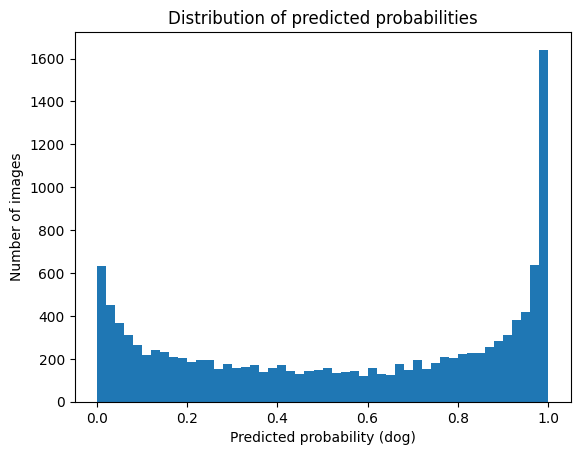

Number of uncertain predictions: 1420
    id     label
12  13  0.513048
28  29  0.503794
32  33  0.558571
50  51  0.523675
54  55  0.443613


In [36]:
# 13. 제출 파일(예측 결과) 분석 및 인사이트 도출

import pandas as pd
import matplotlib.pyplot as plt

# 1. 제출 파일 불러오기
df = pd.read_csv('submission.csv')  # 예측 결과가 저장된 CSV 파일

# 2. 예측 확률 분포 통계 확인
print(df['label'].describe())  # 예측값의 평균, 표준편차 등 기본 통계

# 3. 예측 확률 분포 시각화
plt.hist(df['label'], bins=50)
plt.title('Distribution of predicted probabilities')
plt.xlabel('Predicted probability (dog)')
plt.ylabel('Number of images')
plt.show()

# 4. 불확실(0.4~0.6) 예측 샘플 확인
uncertain = df[(df['label'] > 0.4) & (df['label'] < 0.6)]
print(f"Number of uncertain predictions: {len(uncertain)}")
print(uncertain.head())

# 5. 분석 결과를 바탕으로 개선 아이디어를 메모/정리
# 예) 확률 분포가 한쪽에 치우쳤다면 클래스 불균형, 증강 부족, 모델 단순함 등을 의심
